In [1]:
import pandas as pd
import dask.dataframe as dd 
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import datetime as dt
import gc
import psutil
import multiprocessing
import time
import os
import signal
from os import getpid
from sys import argv, exit
import lightgbm as lgb
import sklearn

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


## Task 1

In [2]:
df = pd.read_fwf("C:/Users/benea/Downloads/UMD_TEST.txt", header=None)

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,1.0,0.017644,0.030949,0.050555,0.044484,0.053277,0.041576,0.030947,0.027086,0.013764,...,0.024575,0.033780,0.026589,0.013932,0.024928,0.022589,0.038248,0.049838,0.053419,0.040420
1,1.0,0.041296,0.003551,0.027470,0.013158,0.009571,0.008074,0.043743,0.040592,0.012190,...,0.060539,0.046991,0.023586,0.001562,-0.002196,0.036730,0.039027,0.007754,0.004697,0.031440
2,1.0,-0.000720,0.013283,0.029450,0.045201,0.006317,0.018805,0.028901,0.013832,0.015240,...,0.016442,0.039508,0.015171,0.034708,0.010835,0.002942,0.006924,0.029502,0.040786,0.023144
3,1.0,0.005201,0.013363,0.025733,0.026653,0.038946,0.012494,0.028303,0.032011,0.009467,...,0.006383,0.037448,0.044335,0.011143,-0.003624,0.001467,0.020991,0.027675,0.001621,0.015858
4,1.0,0.022926,0.027036,0.011668,0.019500,0.036049,-0.001297,0.019717,0.039583,0.020628,...,0.026997,0.036653,0.018117,0.018314,0.012536,0.040599,0.016590,0.032730,0.002498,0.011260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,3.0,0.008298,0.017240,0.010756,0.049488,0.005331,0.036829,0.045530,0.046181,0.044288,...,0.015062,0.028319,0.028443,0.051677,0.036134,0.038030,0.047388,0.006875,0.052691,0.051594
140,3.0,0.004801,0.042964,0.034519,-0.003426,-0.003353,0.005231,0.002309,0.029905,0.011177,...,0.017705,0.045264,0.041434,0.040670,0.034613,0.001551,0.017716,0.001042,0.047787,0.020318
141,3.0,0.033658,0.038235,0.009848,0.016061,0.026287,0.029979,0.024099,0.023647,0.017566,...,0.019306,0.022595,0.014942,0.009259,0.019186,0.035905,0.031095,0.006592,0.017948,-0.003614
142,3.0,0.022805,0.020270,0.015546,0.038309,0.016303,0.011456,0.018286,0.015730,0.007319,...,0.013016,0.030138,0.025736,0.005955,0.050157,0.014435,0.005638,0.036126,0.010751,-0.005682


## 1 - Use the DTW function in the notebook to implement a simple 1-NN classifier for time-series data. 

In [4]:
def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)]) # warping cannot be less than the difference in lengths. 
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[-1,-1]

- Dropping of the class label

In [5]:
df1x = df.drop(0, axis=1)

- seperation of single row to run the stw function on and return the nearest neighbour

In [6]:
test_row = df1x.head(1)
test_df = df1x.tail(143)
test_row

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
0,0.017644,0.030949,0.050555,0.044484,0.053277,0.041576,0.030947,0.027086,0.013764,0.005054,...,0.024575,0.03378,0.026589,0.013932,0.024928,0.022589,0.038248,0.049838,0.053419,0.04042


In [7]:
test_df

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
1,0.041296,0.003551,0.027470,0.013158,0.009571,0.008074,0.043743,0.040592,0.012190,0.032360,...,0.060539,0.046991,0.023586,0.001562,-0.002196,0.036730,0.039027,0.007754,0.004697,0.031440
2,-0.000720,0.013283,0.029450,0.045201,0.006317,0.018805,0.028901,0.013832,0.015240,0.021354,...,0.016442,0.039508,0.015171,0.034708,0.010835,0.002942,0.006924,0.029502,0.040786,0.023144
3,0.005201,0.013363,0.025733,0.026653,0.038946,0.012494,0.028303,0.032011,0.009467,0.048299,...,0.006383,0.037448,0.044335,0.011143,-0.003624,0.001467,0.020991,0.027675,0.001621,0.015858
4,0.022926,0.027036,0.011668,0.019500,0.036049,-0.001297,0.019717,0.039583,0.020628,0.013243,...,0.026997,0.036653,0.018117,0.018314,0.012536,0.040599,0.016590,0.032730,0.002498,0.011260
5,0.004897,0.016985,0.003485,0.006491,0.028674,0.005622,0.006906,0.011857,0.022167,0.003506,...,0.041374,0.030726,0.042439,0.013007,0.034942,0.026134,0.037174,0.025711,0.034479,0.028682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.008298,0.017240,0.010756,0.049488,0.005331,0.036829,0.045530,0.046181,0.044288,0.002914,...,0.015062,0.028319,0.028443,0.051677,0.036134,0.038030,0.047388,0.006875,0.052691,0.051594
140,0.004801,0.042964,0.034519,-0.003426,-0.003353,0.005231,0.002309,0.029905,0.011177,0.038531,...,0.017705,0.045264,0.041434,0.040670,0.034613,0.001551,0.017716,0.001042,0.047787,0.020318
141,0.033658,0.038235,0.009848,0.016061,0.026287,0.029979,0.024099,0.023647,0.017566,0.046848,...,0.019306,0.022595,0.014942,0.009259,0.019186,0.035905,0.031095,0.006592,0.017948,-0.003614
142,0.022805,0.020270,0.015546,0.038309,0.016303,0.011456,0.018286,0.015730,0.007319,0.023773,...,0.013016,0.030138,0.025736,0.005955,0.050157,0.014435,0.005638,0.036126,0.010751,-0.005682


In [11]:
# turned to a numpy array to pass through the dtw function
row1 = test_row.iloc[0].to_numpy()
row1

array([ 1.7644459e-02,  3.0949268e-02,  5.0555110e-02,  4.4484418e-02,
        5.3276844e-02,  4.1576200e-02,  3.0947384e-02,  2.7085506e-02,
        1.3763773e-02,  5.0538801e-03,  4.9583589e-02,  4.7378657e-03,
        2.4308760e-02,  2.4478464e-02,  4.3095075e-02,  3.1740094e-02,
        3.3707003e-02,  4.4220571e-02,  1.2100000e-01,  4.6200000e-01,
        8.1000000e-01,  1.0110000e+00,  1.1070000e+00,  1.1440000e+00,
        1.0270000e+00,  6.8500000e-01,  3.4200000e-01,  1.4900000e-01,
        5.9000000e-02,  5.5992157e-02,  1.1957117e-02,  1.0609106e-02,
        5.3351608e-02,  4.4763044e-02,  2.2176572e-02,  1.3004620e-02,
        2.3660634e-02,  2.2580103e-02,  2.4467768e-02,  3.0559437e-02,
       -4.9870111e-03,  1.9600643e-02,  3.1117836e-02,  2.3833347e-02,
        3.1311257e-02,  3.0431769e-02, -8.4000000e-02, -3.1400000e-01,
       -5.3900000e-01, -6.6200000e-01, -7.2100000e-01, -7.5000000e-01,
       -7.6400000e-01, -7.6900000e-01, -7.7000000e-01, -7.6800000e-01,
      

- processing function so can find the row which has the smallest dtw distance

In [12]:
# arguments are the same as dtw fucntion
def get_dtw_for_row(row, df, window): 
    best_ans = np.inf
    best_row = "unknown"
    ind = "unknown"
# runs the dtw function for every row
    for i in range(0, len(df)):
        r = df.iloc[i].to_numpy()
        euc = dtw(row, r, window)
    # the "best" values are updated every time a better score is found
        if euc < best_ans:
            best_ans = euc
            best_row = i
            ind = df.iloc[[best_row]].index.tolist()[0]
    
# returns the best score and the index number of that row so that can map the row to the class in the next function
    return best_ans, ind
    

- with a window value of one the closest match for the first row in the series is row 11

In [13]:
%%time
print(get_dtw_for_row(row1, test_df, 1))

(17.845580266419994, 11)
CPU times: total: 1.2 s
Wall time: 1.2 s


- 11 and 0 have the same class label of 1.0

In [14]:
df.iloc[[0]]

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,1.0,0.017644,0.030949,0.050555,0.044484,0.053277,0.041576,0.030947,0.027086,0.013764,...,0.024575,0.03378,0.026589,0.013932,0.024928,0.022589,0.038248,0.049838,0.053419,0.04042


In [15]:
df.iloc[[11]]

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
11,1.0,0.024935,0.014623,0.0312,0.005853,0.042486,0.03557,0.032742,0.012054,0.033473,...,0.0212,0.040568,0.045403,0.005464,0.004034,0.019905,0.023834,0.045271,0.039102,0.033346


### 4- Find the best value for the window parameter for this dataset.
- chose to do this earlier as it gave me the best window value to run for parts 2 and 3

best window paramater: 21
(7.218798390019996, 2)


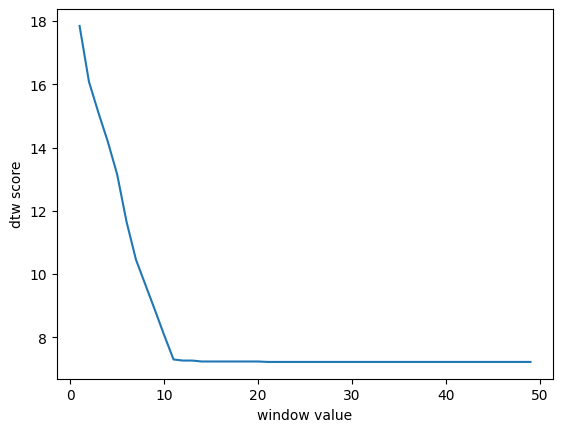

CPU times: total: 5min 17s
Wall time: 5min 17s


In [11]:
%%time
# records in array to plot at then end
winarr = []
scorarr = []

bestscore = np.inf
bestwindow = "none"
# checked values from 1 to 50
for i in range(1, 50):
    winarr.append(i)
    check = get_dtw_for_row(row1, test_df, i)
    scorarr.append(check[0])
    if check[0] < bestscore:
        bestscore = check[0]
        bestwindow = i
print(f"best window paramater: {bestwindow}")
print(get_dtw_for_row(row1, test_df, bestwindow))

 
plt.plot(winarr, scorarr) 
    
# x axis 
plt.xlabel('window value') 
# y axis 
plt.ylabel('dtw score') 
plt.show()

- there's little return after 11 value and it peaks at 21

## 2 - Test the performance of this classifier on the dataset provided in the file UMD_TEST.txt.

- shuffled the set

In [27]:
df1 = shuffle(df)

- split into x and y

In [28]:
y = df1[0]
y

91     2.0
37     1.0
124    3.0
43     1.0
71     2.0
      ... 
15     1.0
51     2.0
32     1.0
101    3.0
119    3.0
Name: 0, Length: 144, dtype: float64

In [29]:
x = df1.drop(0, axis=1)
x

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
91,-0.002655,0.015997,0.008184,0.020402,0.030591,0.020284,0.035713,0.024736,0.034861,0.009023,...,0.041540,0.024471,0.010736,0.011547,0.042622,0.014696,0.040521,0.004279,0.012651,0.047850
37,0.006430,0.046041,0.016700,0.039483,0.008078,0.004831,0.044501,0.012245,0.035441,0.020079,...,0.014971,0.025349,0.027267,0.011987,0.045977,0.025867,0.032953,-0.002189,0.007325,0.040009
124,0.045981,0.012148,0.013264,0.019978,0.047687,0.043812,0.051371,0.014016,0.026985,0.005441,...,0.036997,0.006677,0.000391,0.032803,0.011613,0.053933,0.022790,0.020098,0.046039,0.017384
43,0.019429,0.048879,0.008268,0.027989,0.003587,0.014128,0.028636,0.032954,0.048680,0.045713,...,0.032222,0.031083,0.030808,0.023964,0.054870,0.033465,0.022289,0.029693,0.013050,0.032090
71,0.000887,0.012166,0.040018,0.048424,0.023128,0.018302,0.021351,0.013796,-0.001787,0.011077,...,0.005911,0.000074,0.039616,0.014809,0.010103,0.007459,0.024324,0.026558,0.017794,0.017757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.038966,0.035722,0.051591,0.012550,0.010518,0.030557,0.022885,0.050302,0.012483,0.025588,...,0.017547,0.052987,0.017537,0.047069,0.036060,0.007604,0.014632,0.022638,0.021450,0.026277
51,0.015840,0.021583,0.011872,0.001781,0.036439,0.031705,0.051971,0.016722,0.015715,0.020778,...,0.020353,0.010764,0.020652,0.015120,0.037402,0.032410,0.033558,0.038615,0.002791,0.033798
32,-0.008430,0.012060,0.029846,0.009341,0.009222,0.006756,0.040382,0.016783,0.014935,0.035487,...,0.016202,0.046870,0.040471,0.023166,0.000864,0.036065,0.018637,0.020555,0.000397,0.011646
101,0.009284,0.046141,0.017098,0.017464,0.008781,0.014759,0.007135,0.034011,0.037612,0.003852,...,0.008791,0.032532,0.030340,0.033892,0.033743,0.028494,0.027013,0.008755,0.048172,0.040748


- chose to split the data 40/60

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

- made the y train values a pandas data frame

In [31]:
y_train_df = pd.DataFrame(y_train)

- made lists of the categories to split up and list of indexes which each value

In [32]:
cats = df1[0].tolist()
cats = list(dict.fromkeys(cats))
cats

[2.0, 1.0, 3.0]

In [33]:
y_train_df.loc[135][0]

3.0

In [34]:
ones = []
twos = []
threes = []

y_train_df.index

for j in y_train_df.index:
    this = y_train_df.loc[j][0]
    if this == 1.0:
        ones.append(j)
    elif this == 2:
        twos.append(j)
    else:
        threes.append(j)


In [35]:
threes

[124,
 98,
 127,
 125,
 135,
 139,
 104,
 123,
 110,
 118,
 99,
 122,
 128,
 113,
 108,
 140,
 96,
 111,
 101,
 121,
 114,
 116,
 143,
 134,
 120,
 142,
 97]

In [36]:
len(threes)

27

- Implemented the DTW matcher with the a class mapper and recorded the best match as predicitons

In [37]:
%%time
predictions = []
for i in range(0, len(x_test)):
    test_row = x_test.iloc[i].to_numpy()
    best_match = get_dtw_for_row(test_row, x_train, 21)[1]
# mapped the index value of the nearest neighbour to the array which contained their index
    if best_match in ones:
        guess = 1.0
    elif best_match in twos:
        guess = 2.0
    else:
        guess = 3.0
        
    predictions.append(guess)
    
predictions   

CPU times: total: 3min 14s
Wall time: 3min 14s


[1.0,
 3.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 3.0,
 2.0,
 2.0,
 1.0,
 1.0,
 3.0,
 3.0,
 2.0,
 3.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 3.0,
 3.0,
 3.0,
 2.0,
 3.0,
 1.0,
 1.0,
 3.0,
 3.0,
 1.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 1.0,
 3.0,
 2.0,
 3.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 3.0,
 2.0,
 2.0,
 1.0,
 3.0,
 3.0,
 1.0,
 2.0]

- accuracy score of approximately 95%

In [38]:
accuracy_score(y_test, predictions)

0.9482758620689655

## 3- Compare the 1-NN DTW performance with 1-NN Euclidean.

- imported the sklearn euclidean distances funciton

In [39]:
from sklearn.metrics.pairwise import euclidean_distances

In [41]:
# tester example
euclidean_distances([x_test.iloc[6].tolist()], [x_test.iloc[34].tolist()])[0][0]

12.892543876376955

- Altered the function used for dtw to integrate the euclidean value
- used the same code as before to get the class values

*- p.s I am aware that the default knn sklearn model has a built in euclidean metric option but chose to keep the base code as before for conistency and to make sure I didn't lose marks for cutting corner*

In [88]:
def get_euc_for_row(row, df):
    best_ans = np.inf
    best_row = "unknown"
    ind = "unknown"
    for i in range(0, len(df)):
        r = df.iloc[i].to_numpy()
        euc = euclidean_distances([row], [r])[0][0] # euclidean implemented within copy of previous function
        if euc < best_ans:
            best_ans = euc
            best_row = i
            ind = df.iloc[[best_row]].index.tolist()[0]
            
    return best_ans, ind

In [43]:
%%time
predictions2 = []
for i in range(0, len(x_test)):
    test_row = x_test.iloc[i].to_numpy()
    best_match = get_euc_for_row(test_row, x_train)[1]
    if best_match in ones:
        guess = 1.0
    elif best_match in twos:
        guess = 2.0
    else:
        guess = 3.0
        
    predictions2.append(guess)
    
predictions2   

CPU times: total: 594 ms
Wall time: 599 ms


[1.0,
 3.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 3.0,
 3.0,
 3.0,
 1.0,
 3.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 3.0,
 3.0,
 1.0,
 2.0,
 3.0,
 1.0,
 1.0,
 3.0,
 3.0,
 1.0,
 2.0,
 2.0,
 3.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 3.0,
 2.0,
 1.0,
 1.0,
 3.0,
 3.0,
 1.0,
 2.0]

In [44]:
accuracy_score(y_test, predictions2)

0.8620689655172413

- has a lower accuracy score than dtw

#### chose to compare them by confusion matrix
    - DTW performed better
    - Both Euclidean and DTW were most likely to be wrong when prediciting a value was equal to 2 

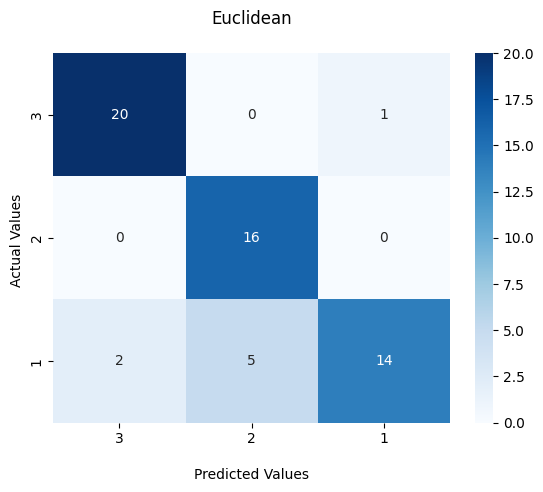

In [87]:
cf_matrix = confusion_matrix(y_test, predictions2)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Euclidean\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(["3","2", "1"])
ax.yaxis.set_ticklabels(["3", "2", "1"])

plt.show()

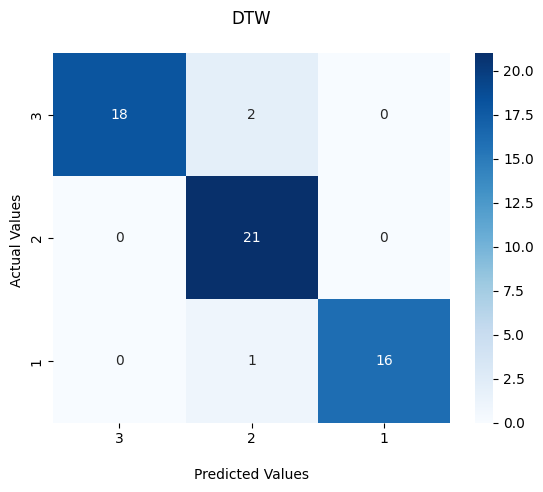

In [70]:
cf_matrix = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('DTW\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(["3","2", "1"])
ax.yaxis.set_ticklabels(["3", "2", "1"])

plt.show()

#### analysis within dataframes

In [51]:
matrix_df = pd.DataFrame(y_test)

In [52]:
matrix_df = matrix_df.rename({0: 'answer'}, axis=1)
matrix_df["dtw_pred"] = predictions
matrix_df["euc_pred"] = predictions2
matrix_df

,answer,dtw_pred,euc_pred
33,1.0,1.0,1.0
112,3.0,3.0,3.0
24,1.0,1.0,1.0
57,2.0,2.0,2.0
58,2.0,2.0,2.0
75,2.0,2.0,2.0
29,1.0,1.0,1.0
60,2.0,2.0,2.0
133,3.0,3.0,2.0
59,2.0,2.0,2.0


- 8 instances where the two models had different predicitons

In [53]:
matrix_df.loc[(matrix_df.dtw_pred != matrix_df.euc_pred)]

,answer,dtw_pred,euc_pred
133,3.0,3.0,2.0
4,1.0,1.0,3.0
30,1.0,2.0,1.0
107,3.0,3.0,1.0
109,3.0,3.0,1.0
129,3.0,3.0,2.0
137,3.0,3.0,2.0
136,3.0,3.0,2.0
37,1.0,2.0,1.0


In [54]:
matrix_df.loc[(matrix_df.answer != matrix_df.euc_pred)]

,answer,dtw_pred,euc_pred
133,3.0,3.0,2.0
4,1.0,1.0,3.0
132,3.0,2.0,2.0
107,3.0,3.0,1.0
109,3.0,3.0,1.0
129,3.0,3.0,2.0
137,3.0,3.0,2.0
136,3.0,3.0,2.0


In [55]:
matrix_df.loc[(matrix_df.answer != matrix_df.dtw_pred)]

,answer,dtw_pred,euc_pred
30,1.0,2.0,1.0
132,3.0,2.0,2.0
37,1.0,2.0,1.0


#### conclusions
- DTW is a better prediction of the time seires data given.
- The best window value for the data set was 21 although there was little difference in changing the value after 11
- It is possible to have a very prediction of time series data using Dynamic Time Warping

## Task 2

### 1 - Adapt the DTW code provided so that it can be incorporated  in a scikit-learn k-NN  classifier. 

- kept the transposed function the same but set the default window value to 21

In [47]:
def dtw(s, t, window=21): # set window as 21 
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)]) # warping cannot be less than the difference in lengths. 
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[-1,-1]

In [48]:
knn = KNeighborsClassifier(n_neighbors=1, metric = dtw) 
knn.fit(x_train, y_train)

KNeighborsClassifier(metric=<function dtw at 0x0000017D11D25120>, n_neighbors=1)

### 2- Test the performance of this classifier and compare with the 1-NN results from Task 1. Verify that the 1-NN results are consistent. 

In [50]:
%%time 
pred_custom = knn.predict(x_test)

CPU times: total: 3min 10s
Wall time: 3min 10s


In [56]:
accuracy_score(y_test, pred_custom)

0.9482758620689655

In [57]:
matrix_df["cust_met_pred"] = pred_custom

###### predictions are idneitcal for both instances

In [58]:
matrix_df.loc[(matrix_df.answer != matrix_df.cust_met_pred)]

,answer,dtw_pred,euc_pred,cust_met_pred
30,1.0,2.0,1.0,2.0
132,3.0,2.0,2.0,2.0
37,1.0,2.0,1.0,2.0


In [59]:
matrix_df.loc[(matrix_df.answer != matrix_df.dtw_pred)]

,answer,dtw_pred,euc_pred,cust_met_pred
30,1.0,2.0,1.0,2.0
132,3.0,2.0,2.0,2.0
37,1.0,2.0,1.0,2.0


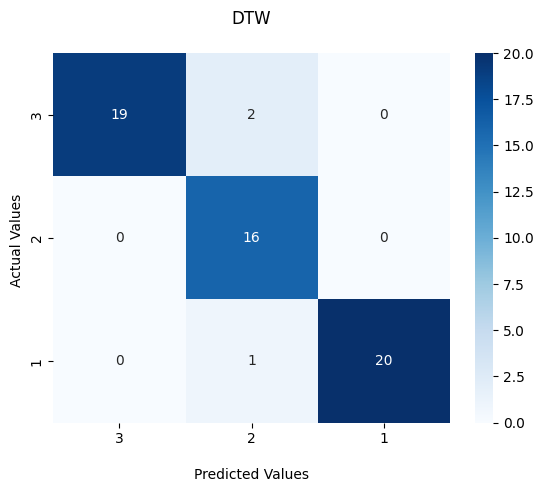

In [60]:
cf_matrix = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('DTW\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(["3","2", "1"])
ax.yaxis.set_ticklabels(["3", "2", "1"])

plt.show()

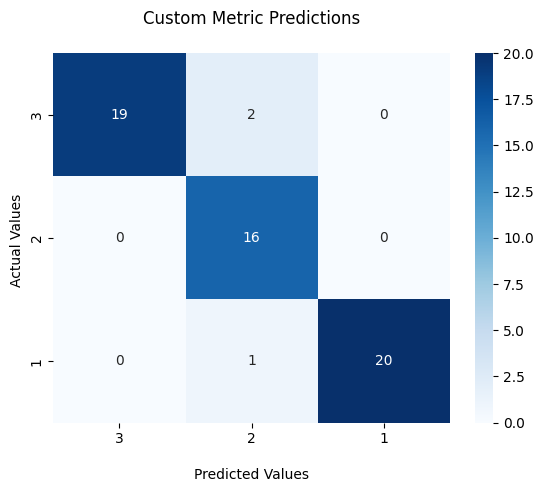

In [61]:
cf_matrix = confusion_matrix(y_test, pred_custom)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Custom Metric Predictions\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(["3","2", "1"])
ax.yaxis.set_ticklabels(["3", "2", "1"])

plt.show()

### 3 - Compare with k-NN Euclidean. 

- Felt as though this question was ambiguous so chose to evaluate different values of K within it

In [ ]:
%%time
# records in array to plot at then end
winarr = []
scorarr = []

bestscore = np.inf
bestwindow = "none"
# checked values from 1 to 50
for i in range(1, 50):
    winarr.append(i)
    check = get_dtw_for_row(row1, test_df, i)
    scorarr.append(check[0])
    if check[0] < bestscore:
        bestscore = check[0]
        bestwindow = i
print(f"best window paramater: {bestwindow}")
print(get_dtw_for_row(row1, test_df, bestwindow))

 
plt.plot(winarr, scorarr) 
    
# x axis 
plt.xlabel('window value') 
# y axis 
plt.ylabel('dtw score') 
plt.show()

In [97]:
%%time
kval = []
scorval = []

for K in range(1, 26):
    kval.append(K)
    knn1 = KNeighborsClassifier(n_neighbors=K, metric='euclidean')
    knn1.fit(x_train, y_train)
    preds1 = knn1.predict(x_test)
    
    score = accuracy_score(y_test, preds1)
    scorval.append(score)
    print(f"accuracy score for k value of {K}: {score}")


accuracy score for k value of 1: 0.8620689655172413
accuracy score for k value of 2: 0.8103448275862069
accuracy score for k value of 3: 0.8275862068965517
accuracy score for k value of 4: 0.8275862068965517
accuracy score for k value of 5: 0.7586206896551724
accuracy score for k value of 6: 0.7586206896551724
accuracy score for k value of 7: 0.7586206896551724
accuracy score for k value of 8: 0.7241379310344828
accuracy score for k value of 9: 0.7068965517241379
accuracy score for k value of 10: 0.7068965517241379
accuracy score for k value of 11: 0.6724137931034483
accuracy score for k value of 12: 0.6896551724137931
accuracy score for k value of 13: 0.6551724137931034
accuracy score for k value of 14: 0.6896551724137931
accuracy score for k value of 15: 0.6896551724137931
accuracy score for k value of 16: 0.6724137931034483
accuracy score for k value of 17: 0.6724137931034483
accuracy score for k value of 18: 0.6551724137931034
accuracy score for k value of 19: 0.6206896551724138
ac

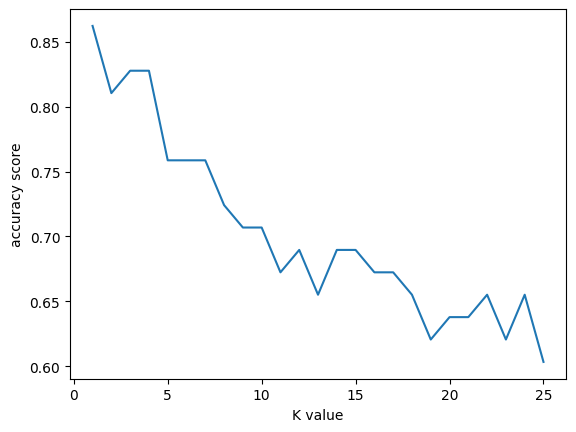

In [99]:
plt.plot(kval, scorval) 
    
# x axis 
plt.xlabel('K value') 
# y axis 
plt.ylabel('accuracy score') 
plt.show()

##### best K value for the dataset is 1 although it's worth noting that 3 and 4 are better than 2

In [100]:
knn1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

In [101]:
knn1.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [102]:
preds1 = knn1.predict(x_test)

In [103]:
score = accuracy_score(y_test, preds1)
print(f"accuracy score: {score}")

accuracy score: 0.8620689655172413


In [108]:
matrix_df["euclidean_knn"] = preds1

In [110]:
matrix_df.loc[(matrix_df.answer != matrix_df.euclidean_knn)]

,answer,dtw_pred,euc_pred,cust_met_pred,euclidean_knn
133,3.0,3.0,2.0,3.0,2.0
4,1.0,1.0,3.0,1.0,3.0
132,3.0,2.0,2.0,2.0,2.0
107,3.0,3.0,1.0,3.0,1.0
109,3.0,3.0,1.0,3.0,1.0
129,3.0,3.0,2.0,3.0,2.0
137,3.0,3.0,2.0,3.0,2.0
136,3.0,3.0,2.0,3.0,2.0


In [115]:
matrix_df.loc[(matrix_df.answer != matrix_df.cust_met_pred)]

,answer,dtw_pred,euc_pred,cust_met_pred,euclidean_knn
30,1.0,2.0,1.0,2.0,1.0
132,3.0,2.0,2.0,2.0,2.0
37,1.0,2.0,1.0,2.0,1.0


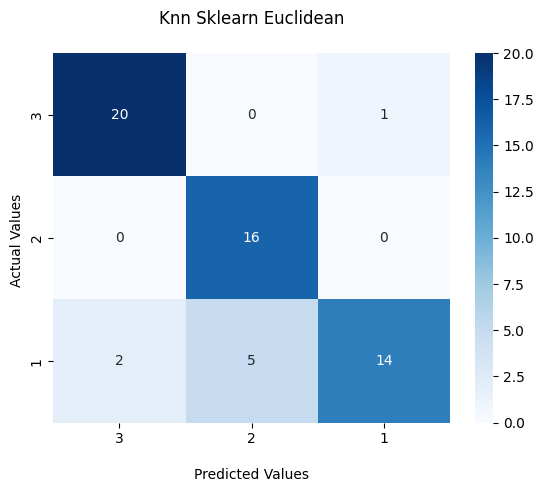

In [113]:
cf_matrix = confusion_matrix(y_test, preds1)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Knn Sklearn Euclidean\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(["3","2", "1"])
ax.yaxis.set_ticklabels(["3", "2", "1"])

plt.show()

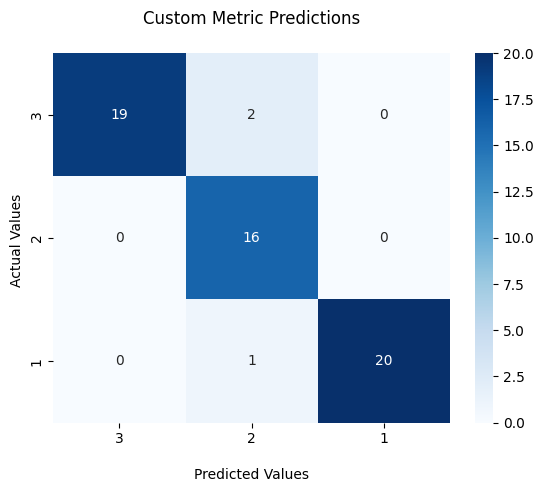

In [114]:
cf_matrix = confusion_matrix(y_test, pred_custom)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Custom Metric Predictions\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(["3","2", "1"])
ax.yaxis.set_ticklabels(["3", "2", "1"])

plt.show()

#### Conclusions
- DTW when used in a custom function for sklearn's Knn model is a better predicter that the built in Euclidiean model
- The Sklearn Euclidean model was more likely to predict a class value of 2 when the actual value was 1 on the data set than the DTW custom metric model
- Using custom metrics within machine learning models for time series data